## Voting Classifier 

**VotingClassifier** es un modelo de aprendizaje automático **"conjunto"** que combina las **predicciones de otros modelos**.

**Es una técnica que se puede utilizar para mejorar el rendimiento del modelo**, idealmente logrando un mejor rendimiento que cualquier modelo único utilizado en el conjunto.

**VotingClassifier** funciona combinando las predicciones de múltiples modelos. Se puede utilizar para clasificación o regresión. En el caso de la regresión, esto implica calcular el promedio de las predicciones de los modelos. En el caso de la clasificación, se suman las predicciones para cada etiqueta y se predice la etiqueta con el voto mayoritario.

**VotingClassifier** no garantiza que el conjunto de modelos proporcione un mejor rendimiento que cualquier modelo único utilizado en el conjunto. Si algún modelo utilizado en el conjunto funciona mejor que el conjunto de votación, probablemente sea mejor usar ese modelo en lugar del conjunto de votación.

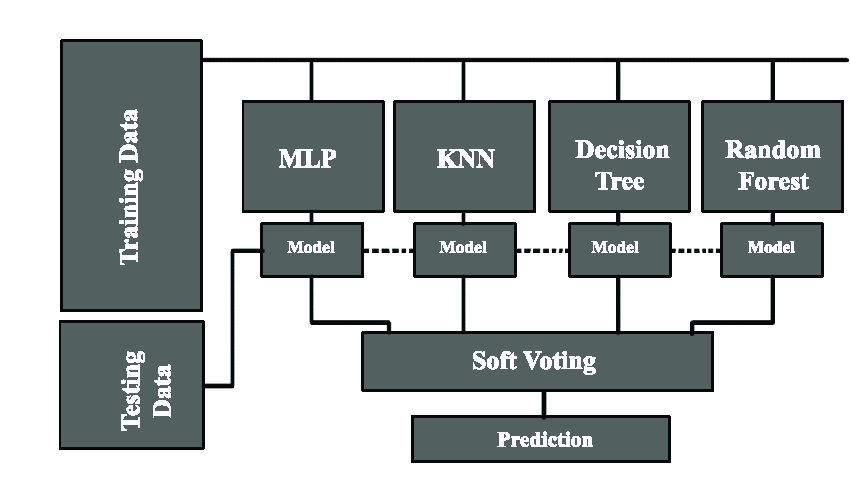

_**Documentacion:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html_

In [6]:
import numpy as np
import pandas as pd

import matplotlib # Para ver la versión
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn # Para ver la versión

from sklearn import datasets

# Normalizacion
from sklearn.preprocessing import MinMaxScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Train, Test
from sklearn.model_selection import train_test_split

# Metricas
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Clasificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Validacion
from sklearn.model_selection import StratifiedKFold

In [7]:
# Versiones

print(f"numpy=={np.__version__}")
print(f"pandas=={pd.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"seaborn=={sns.__version__}")
print(f"scikit-learn=={sklearn.__version__}")

numpy==1.20.3
pandas==1.2.4
matplotlib==3.4.2
seaborn==0.11.1
scikit-learn==1.5.1


In [8]:
df = pd.read_excel("../Data/credit_card_clients.xls")

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
df.shape

(30000, 25)

In [10]:
df["default payment next month"].value_counts(normalize = True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

### Preprocesamiento

In [11]:
# Drop columna "ID"
df.drop("ID", axis = 1)

# Renombrar la columna objetivo
df = df.rename(columns = {"default payment next month" : "class"})

# Transformaciones a las columnas continuas
df["AGE"] = np.log(df["AGE"])
df["LIMIT_BAL"] = np.log(df["LIMIT_BAL"])

df["MARRIAGE"].replace({0 : 3}, inplace = True)

# Drop de columnas
df.drop(["BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"], axis = 1, inplace = True)

# Filtro de datos
df = df[df["PAY_0"].isin([-2, -1, 0, 1, 2])]
df = df[df["PAY_2"].isin([-2, -1, 0, 1, 2])]
df = df[df["PAY_3"].isin([-2, -1, 0, 1, 2])]
df = df[df["PAY_4"].isin([-2, -1, 0, 1, 2])]
df = df[df["PAY_5"].isin([-2, -1, 0, 1, 2])]
df = df[df["PAY_6"].isin([-2, -1, 0, 1, 2])]

df.reset_index(drop = True, inplace = True)

In [12]:
X = df.drop("class", axis = 1)
y = df["class"]

X.shape, y.shape

((28807, 19), (28807,))

### Train, Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (20164, 19), y_train: (20164,)
X_test: (8643, 19),  y_test: (8643,)


### Preprocesamiento

In [14]:
# Escalado de datos

x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

### Modelo

In [16]:
from sklearn.ensemble import VotingClassifier

In [17]:
model0 = KNeighborsClassifier(3, n_jobs = -1)

model1 = LogisticRegression(solver = "liblinear", multi_class = "auto")

model2 = RandomForestClassifier(n_estimators = 100)

model3 = GaussianNB()

model4 = AdaBoostClassifier(n_estimators = 200)

model5 = NearestCentroid()

In [24]:
estimadores = [("knn", model0), ("lr", model1), ("rf", model2), ("gnb", model3), ("ab", model4)]

In [25]:
type(estimadores[0])

tuple

In [27]:
%%time

model = VotingClassifier(estimators = estimadores,
                             voting = "soft",
                            weights = [1, 1, 1, 1, 1],
                             n_jobs = -1)

model.fit(X_train, y_train)

# voting = "soft" nos permite utilizar .predict_proba()
# Si voting = "soft" todos los estimadores (modelos) deben tener ese método
# De lo contrario .predict_proba() nos dará error

CPU times: user 117 ms, sys: 188 ms, total: 305 ms
Wall time: 15.1 s


VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=3)),
                             ('lr',
                              LogisticRegression(multi_class='auto',
                                                 solver='liblinear')),
                             ('rf', RandomForestClassifier()),
                             ('gnb', GaussianNB()),
                             ('ab', AdaBoostClassifier(n_estimators=200))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 1, 1, 1])

In [28]:
# display(model)

- **`voting = "soft"`**: Suma todas las probabilidades y selecciona la mayor. Solo se puede usar si todos los estimadores calculan la probabilidad de pertenecer a una clase o a otra. En caso de tener un estimador que no tenga el método **`predict_proba()`**, éste se omitará del modelo.


- **`voting = "hard"`**: Utiliza la moda de las predicciones de cada modelo. Puede ser usado con todos los modelos.

### Predicciones

In [29]:
yhat = model.predict(X_test)

yhat

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
print("Jaccard Index:", jaccard_score(y_test, yhat, average = "macro"))
print("Accuracy:"     , accuracy_score(y_test, yhat))
print("Precisión:"    , precision_score(y_test, yhat, average = "macro"))
print("Sensibilidad:" , recall_score(y_test, yhat, average = "macro"))
print("F1-score:"     , f1_score(y_test, yhat, average = "macro"))
print("ROC AUC:"      , roc_auc_score(y_test, yhat))

Jaccard Index: 0.558263728268999
Accuracy: 0.8183501099155386
Precisión: 0.7186890980704295
Sensibilidad: 0.6659629213599717
F1-score: 0.6843807340345777
ROC AUC: 0.6659629213599716


### Confusion Matrix

In [31]:
confusion_matrix(y_test, yhat, labels = [0, 1])

array([[6352,  525],
       [1045,  721]])

### Atributos y Métodos

In [32]:
# .predict_proba()

model.predict_proba(X_test)

# Solo cuando voting = "soft"

array([[0.6987886 , 0.3012114 ],
       [0.80708846, 0.19291154],
       [0.67899321, 0.32100679],
       ...,
       [0.61662806, 0.38337194],
       [0.51467666, 0.48532334],
       [0.66437285, 0.33562715]])

In [33]:
# .estimators_ nos retorna una lista de tuplas con los modelos utilizados

model.estimators

[('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=3)),
 ('lr', LogisticRegression(multi_class='auto', solver='liblinear')),
 ('rf', RandomForestClassifier()),
 ('gnb', GaussianNB()),
 ('ab', AdaBoostClassifier(n_estimators=200))]

In [34]:
# .transform() retorna una matriz
# Cada fila son los elementos de X_test con las probabilidades de pertenecer a las clases
# Estas filas tienen n_estimators*n_classes
# En nuestro caso tiene 5*2 = 10
# Cada par de elementos (en este ejemplo) es la probabilidad de cada modelo
# La suma de cada par es igual a 1

predict_models = model.transform(X_test)

predict_models

array([[1.        , 0.        , 0.71575423, ..., 0.6739813 , 0.50217004,
        0.49782996],
       [1.        , 0.        , 0.95448306, ..., 0.33294598, 0.50390523,
        0.49609477],
       [0.66666667, 0.33333333, 0.83342603, ..., 0.53815621, 0.50302958,
        0.49697042],
       ...,
       [1.        , 0.        , 0.67513818, ..., 0.95363678, 0.50163888,
        0.49836112],
       [0.33333333, 0.66666667, 0.72085046, ..., 0.75263926, 0.50183878,
        0.49816122],
       [1.        , 0.        , 0.89929051, ..., 0.67985354, 0.5024273 ,
        0.4975727 ]])

In [35]:
predict_models[0]

array([1.        , 0.        , 0.71575423, 0.28424577, 0.95      ,
       0.05      , 0.3260187 , 0.6739813 , 0.50217004, 0.49782996])

In [36]:
columnas = list()

for modelo in model.estimators:
    for clase in model.classes_:
        columnas.append(f"{modelo[0]}_{clase}")
        
df_proba = pd.DataFrame(data = predict_models, columns = columnas)
df_proba["y_test"] = y_test.values
df_proba["yhat"] = yhat

df_proba.head(10)

,knn_0,knn_1,lr_0,lr_1,rf_0,rf_1,gnb_0,gnb_1,ab_0,ab_1,y_test,yhat
0,1.000000,0.000000,0.715754,0.284246,0.95,0.05,0.326019,6.739813e-01,0.502170,0.497830,0,0
1,1.000000,0.000000,0.954483,0.045517,0.91,0.09,0.667054,3.329460e-01,0.503905,0.496095,0,0
2,0.666667,0.333333,0.833426,0.166574,0.93,0.07,0.461844,5.381562e-01,0.503030,0.496970,0,0
3,0.666667,0.333333,0.805947,0.194053,0.82,0.18,0.376985,6.230149e-01,0.502451,0.497549,1,0
4,0.666667,0.333333,0.845725,0.154275,0.93,0.07,0.516110,4.838902e-01,0.503306,0.496694,0,0
5,1.000000,0.000000,0.918072,0.081928,0.89,0.11,0.993793,6.207348e-03,0.502623,0.497377,0,0
6,1.000000,0.000000,0.841356,0.158644,0.86,0.14,1.000000,6.870699e-09,0.502298,0.497702,0,0
7,1.000000,0.000000,0.953495,0.046505,0.82,0.18,0.436695,5.633052e-01,0.502034,0.497966,0,0
8,0.333333,0.666667,0.793120,0.206880,0.62,0.38,0.010120,9.898795e-01,0.501861,0.498139,0,1
9,0.000000,1.000000,0.630048,0.369952,0.52,0.48,0.000569,9.994311e-01,0.500146,0.499854,1,1


In [44]:
# graficar precision y recall (mañana)

In [37]:
pred = model.predict_proba(X_test)[:, 1]

pred

array([0.3012114 , 0.19291154, 0.32100679, ..., 0.38337194, 0.48532334,
       0.33562715])

In [46]:
precision_score

<function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [ ]:
%%time

roc_auc_list = list()

for thresh in [i/50 for i in range(1, 50)]:

    yhat_2 = list()
    
    for p in pred:
        if p <= thresh:
            yhat_2.append(0)
        else:
            yhat_2.append(1)

    roc_auc_list.append([thresh, roc_auc_score(y_test, yhat_2),precision_score(y_test, yhat_2),
                         recall_score(y_test, yhat_2),accuracy_score(y_test, yhat_2)])

In [57]:
df_roc_auc = pd.DataFrame(data = roc_auc_list, columns = ["thresh", "roc_auc", 'precision', 'recall' , "accuracy"])

#df_roc_auc.sort_values("roc_auc", ascending = False)

<AxesSubplot:xlabel='thresh', ylabel='recall'>

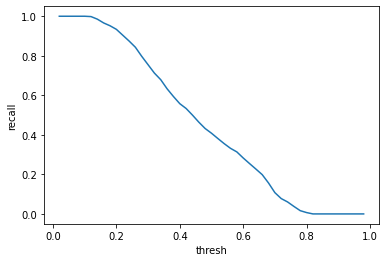

In [58]:
sns.lineplot(data = df_roc_auc, x = "thresh", y = "recall")

<AxesSubplot:xlabel='thresh', ylabel='precision'>

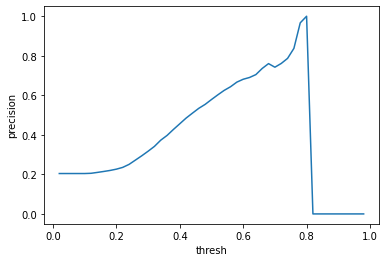

In [59]:
sns.lineplot(data = df_roc_auc, x = "thresh", y = "precision")

In [42]:
df["class"].value_counts(normalize = True)

0    0.795675
1    0.204325
Name: class, dtype: float64

### Validacion

In [ ]:
%%time

skfold = StratifiedKFold(n_splits = 10)
skfold.get_n_splits(X, y)

yhat = list()
y_test_real = list()

for train_index, test_index in skfold.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Escalado de datos
    x_scaler = MinMaxScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    # Modelo
    model = VotingClassifier(estimators = [("knn", model0), ("lr", model1), ("rf", model2), ("gnb", model3), ("ab", model4)],
                             voting     = "soft",
                             weights    = [1, 1, 1, 1, 1],
                             n_jobs     = -1)
    
    model.fit(X_train, y_train)
    
    # Prediccion
    yhat1 = model.predict(X_test)
    yhat.extend(yhat1)
    
    # Valores reales
    y_test_real.extend(y_test)
    
print("Jaccard Index:", jaccard_score(y_test_real, yhat, average = "macro"))
print("Accuracy:"     , accuracy_score(y_test_real, yhat))
print("Precisión:"    , precision_score(y_test_real, yhat, average = "macro"))
print("Sensibilidad:" , recall_score(y_test_real, yhat, average = "macro"))
print("F1-score:"     , f1_score(y_test_real, yhat, average = "macro"))
print("ROC AUC:"      , roc_auc_score(y_test_real, yhat))

In [ ]:
################################################################################################################################

### Exportar modelos

In [ ]:
import pickle

with open("voting_model.sav", "wb") as file:
    pickle.dump(model, file)

### Importar modelos

In [ ]:
with open("voting_model.sav", "rb") as file:
    model = pickle.load(file)

In [ ]:
model.estimators

In [ ]:
################################################################################################################################